# Student Performance Prediction

## Setup: imports and useful functions

In [58]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip

!mkdir dataset
!unzip student.zip -d dataset

--2020-09-18 16:21:12--  http://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20478 (20K) [application/x-httpd-php]
Saving to: ‘student.zip.1’

student.zip.1       100%[===================>]  20.00K  --.-KB/s    in 0.06s   

2020-09-18 16:21:12 (354 KB/s) - ‘student.zip.1’ saved [20478/20478]

mkdir: cannot create directory ‘dataset’: File exists
Archive:  student.zip
replace dataset/student-mat.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/student-mat.csv  
replace dataset/student-por.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/student-por.csv  
replace dataset/student-merge.R? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/student.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import where
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from numpy.random import randint
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#### Functions for analysing dataset

In [60]:
def print_attributes_description(filename='dataset/student.txt'):
  with open(filename, 'r') as fp:
    for row in fp.readlines():
      if not row[0].isdigit():
        continue
      split_index = row.find('-')
      name = row[0:split_index-1]
      description = row[split_index+1:]
      print(name, ":", description)

def get_equal_rows(df1, df2):
  comparison_df = pd.concat([df1, df2])
  duplicates = comparison_df[comparison_df.duplicated(["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"])]
  return len(duplicates)

def print_correlation_matrix(correlation, title):
  fig, ax = plt.subplots(1,1,figsize=(15,10))
  correlation.style.background_gradient(cmap='Blues').set_precision(2)
  sns.heatmap(correlation, cmap='Blues', ax=ax, annot=True, fmt='.1g')
  ax.set_title(title, fontsize=18, y=1.05)




#### Data preprocessing functions

In [61]:
def from_categorical_to_binary_values(data):
  # map {yes, no} to {1,0}
  binary_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 
                     'activities', 'nursery', 'higher', 'internet', 'romantic', 'paid']
  for feature in binary_features:
    if feature in ['schoolsup', 'famsup', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'paid']:
      data[feature] = np.where(data[feature]=='yes', 1, 0)
    elif feature is 'school':
      data[feature] = np.where(data[feature]=='GP', 1, 0)
    elif feature is 'sex':
      data[feature] = np.where(data[feature]=='F', 1, 0)
    elif feature is 'address':
      data[feature] = np.where(data[feature]=='U', 1, 0)
    elif feature is 'famsize':
      data[feature] = np.where(data[feature]=='LE3', 1, 0)
    elif feature is 'Pstatus':
      data[feature] = np.where(data[feature]=='T', 1, 0)

  return data

def one_hot_encoding_nominal_features(data):
  nominal_features = ['Mjob', 'Fjob', 'reason', 'guardian']
  dummies = pd.get_dummies(data[nominal_features])
  data = pd.concat([data, dummies], axis=1)
  data = data.drop(columns=nominal_features)
  return data
    
def bootstrap(X, bootstrap_size=400):
  # create bootstrap of X of given size
  current_samples = len(X)
  indexes_b = randint(0, current_samples, bootstrap_size)
  X_bootstraps = X.iloc[indexes_b].copy()
  return X_bootstraps

def estimate_mean_stdev_with_bootstrap(X, n_bootstraps, bootstrap_size=400):
  # create n_bootstraps sets from X and use it to calculate more precise stats
  X_bootstrap_sets = [bootstrap(X, bootstrap_size) for _ in range(n_bootstraps)]
  means = [X_set.mean() for X_set in X_bootstrap_sets]
  stdevs = [X_set.std() for X_set in X_bootstrap_sets]

  est_mean = pd.DataFrame(means).mean()
  est_stdev = pd.DataFrame(stdevs).mean()

  err_mean = (pd.DataFrame([(est_mean-x)**2 for x in means]).sum()/(len(X_bootstrap_sets)-1))**0.5
  err_stds = (pd.DataFrame([(est_stdev-x)**2 for x in stdevs]).sum()/(len(X_bootstrap_sets)-1))**0.5

  return est_mean, est_stdev, err_mean, err_stds


#### Plots functions

In [62]:
def plot_histograms(df, columns, title, color, figsize=(12,5), legend=True):
  plt.style.use('ggplot')
  df.hist(column=columns, figsize=figsize, rwidth=0.5, color=color)
  plt.title(title, fontsize=18, y=1.05)
  plt.xlabel(columns[0])
  plt.ylabel('Number of students')
  plt.xticks(np.arange(21), np.arange(21))
  plt.show()

def print_histograms(data, subtitles=None, title='insert_title', figsize=(27,5)):
  plt.style.use('ggplot')
  shape = data.shape
  n_isto =  shape[1]
  fig, ax = plt.subplots(1, n_isto, figsize=figsize, sharey=False)
  maxy = []
  for i in range(n_isto):
    x = data[:,i]
    possible_grades = np.arange(21) # possible grades from 0 to 21
    values = [len(x[x == i]) for i in possible_grades] # count the number of students per grade
    values, _, _ = ax[i].hist(x, np.arange(22), density=False, rwidth=0.8)
    if subtitles is not None:
      ax[i].set_title(subtitles[i], fontsize=14)
    plt.sca(ax[i])
    ax[i].set_xlim((-0.5,21.5))
    ax[i].set_xlabel('Grades')
    ax[i].set_ylabel('Number of Students')
    plt.xticks(np.arange(21)+.5, np.arange(21))
    maxy.append(max(values))
  fig.suptitle(title, fontsize=24, y=0.98)
  fig.subplots_adjust(top=0.85)
  maxy = max(maxy)
  for i in range(n_isto):
    ax[i].set_ylim((0,maxy+5))

def plot_df_means(X1_mean, X2_mean, label1, label2, title, figsize=(10,5)):
  plt.figure(figsize=figsize)
  plt.bar(X1_mean.index, X1_mean, color='red', label=label1)
  plt.bar(X2_mean.index, X2_mean, color='blue', label=label2)
  plt.xticks(rotation='vertical')
  plt.title(title, fontsize=18)
  plt.legend()
  plt.show()

def plot_explained_variance(explained_variance, title):
  plt.style.use('ggplot')
  plt.figure(figsize=(7,7))
  plt.plot(np.cumsum(explained_variance))
  plt.title(title)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variance')
  # plot vertical line for  y=variance=90%
  line = plt.gca().get_lines()[0]
  x = line.get_xdata()
  y = line.get_ydata().round(2)
  index_90th = np.where(y == 0.91)
  x_90th = x[index_90th]
  plt.axvline(x=x_90th, marker='.', ls='--', color='blue', label='90% variance')
  plt.legend()
  plt.show()
  return x_90th

def make_meshgrid(X0, X1, h):
    """
    Create a mesh of points to be plotted
    :param X0: data to base x-axis meshgrid on
    :param X1:  data to base y-axis meshgrid on
    :param h: stepsize for meshgrid
    :return: nd arrays
    """
    x_min, x_max = X0.min() - 1, X0.max() + 1
    y_min, y_max = X1.min() - 1, X1.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_decision_boundaries(ax, clf, xx, yy, n_features, **params):
    """
    Plot decision boundaries of the given classifier
    :param ax: axes of the matplotlib object
    :param clf: classifier
    :param xx: nd array
    :param yy: nd array
    :param params: parameters to pass to countours
    :return: contours
    """
    Xpred = np.array([xx.ravel(), yy.ravel()] + [np.repeat(0, xx.ravel().size) for _ in range(n_features-2)]).T
    Z = clf.predict(Xpred)
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, **params)
    return contours

def decision_boundaries(X_test, y_test, str, clf):
  figure, axes = plt.subplots(1, 1)
  print(X_test)
  print("n_features: ",len(X_test.columns))
  X0, X1 = X_test['PC0'], X_test['PC1']
  xx, yy = make_meshgrid(X0, X1, 0.2)
  plot_decision_boundaries(axes, clf, xx, yy, n_features=len(X_test.columns), cmap=plt.cm.coolwarm, alpha=0.8)
  axes.scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
  axes.set_xlim(xx.min(), xx.max())
  axes.set_ylim(yy.min(), yy.max())
  axes.set_xlabel('PC1')
  axes.set_ylabel('PC2')
  axes.set_title(str) 

## Dataset Analysis

In [63]:
data_por = pd.read_csv('dataset/student-por.csv', ';')
data_math = pd.read_csv('dataset/student-mat.csv', ';')

In [64]:
data_por.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [65]:
data_por.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12


In [66]:
data_math.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [67]:
data_math.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10


### Attributes Description

In [68]:
print_attributes_description()
print("Number of features in Math dataset: ", len(data_math.columns))
print("Number of features in Portuguese dataset: ", len(data_por.columns))

1 school :  student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)

2 sex :  student's sex (binary: "F" - female or "M" - male)

3 age :  student's age (numeric: from 15 to 22)

4 address :  student's home address type (binary: "U" - urban or "R" - rural)

5 famsize :  family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)

6 Pstatus :  parent's cohabitation status (binary: "T" - living together or "A" - apart)

7 Medu :  mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)

8 Fedu :  father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)

9 Mjob :  mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")

10 Fjob :  father's job (nominal: "teacher", "health" care related, civil "services"

In [69]:
# Check missing values
null_math = data_math.isna().sum().sum()
null_port = data_por.isna().sum().sum()
print("Missing values in Math dataset: ", null_math)
print("Missing values in Portuguese dataset: ", null_port)

Missing values in Math dataset:  0
Missing values in Portuguese dataset:  0


In [70]:
# Identify students belonging to both Portoguese and Math classes, by looking 
# for identical attributes values
duplicates = get_equal_rows(data_math, data_por)
print("Students belonging only to Portoguese class: {:d} out of {:d}".format(len(data_por)-duplicates, len(data_por)))
print("Students belonging only to Math class: {:d} out of {:d}".format(len(data_math)-duplicates, len(data_math)))
print("Students belonging to both classes: {:d} out of {:d}".format(duplicates, len(data_math)+len(data_por)))

Students belonging only to Portoguese class: 267 out of 649
Students belonging only to Math class: 13 out of 395
Students belonging to both classes: 382 out of 1044


### Features Distribution

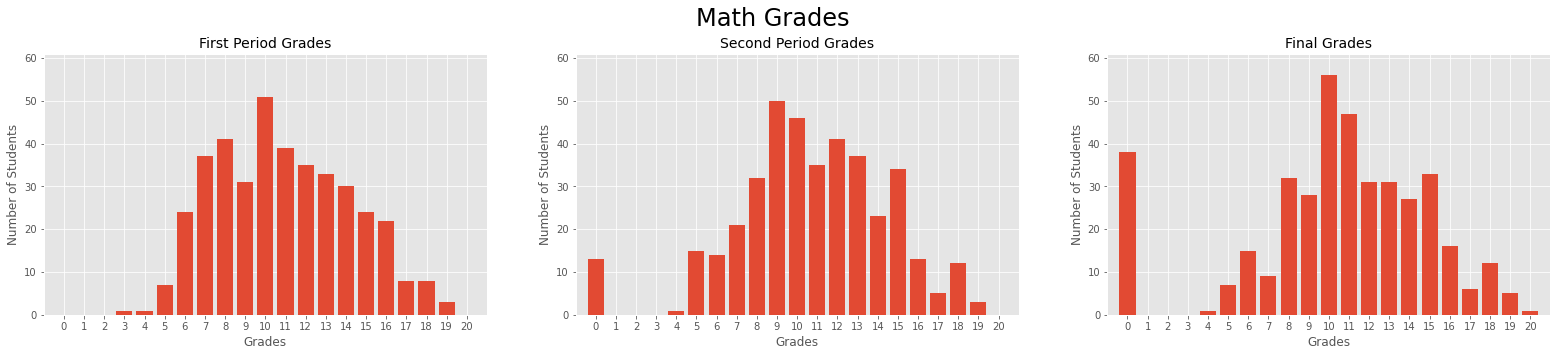

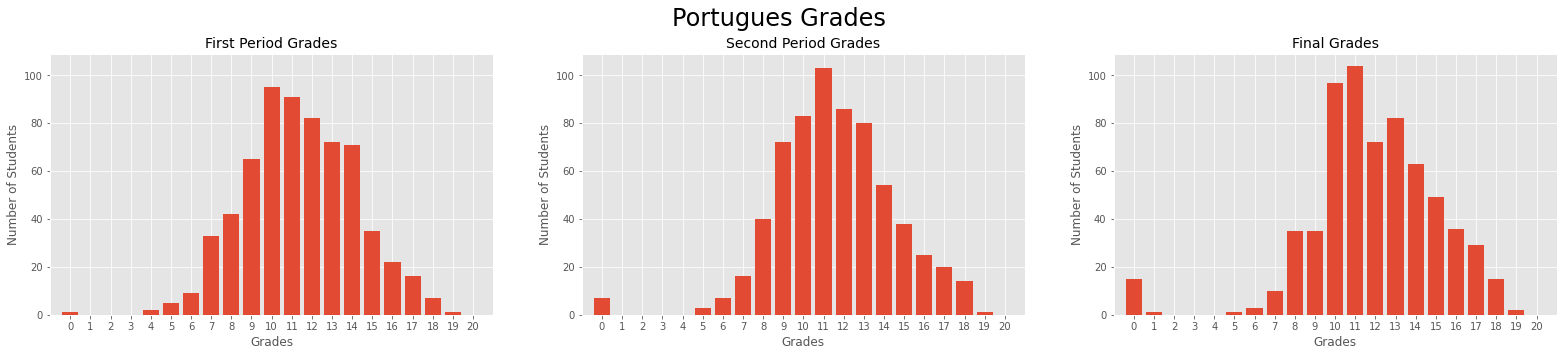

In [71]:
# Grades distribution
# plot_histograms(data_math, ['G3'], title='Math final grades distribution', color='red')
# plot_histograms(data_por, ['G3'], title='Portuguese final grades distribution', color='blue')
print_histograms(data_math[['G1', 'G2', 'G3']].to_numpy(), title='Math Grades', 
                 subtitles=['First Period Grades', 'Second Period Grades', 'Final Grades'])
print_histograms(data_por[['G1', 'G2', 'G3']].to_numpy(), title='Portugues Grades',
                 subtitles=['First Period Grades', 'Second Period Grades', 'Final Grades'])



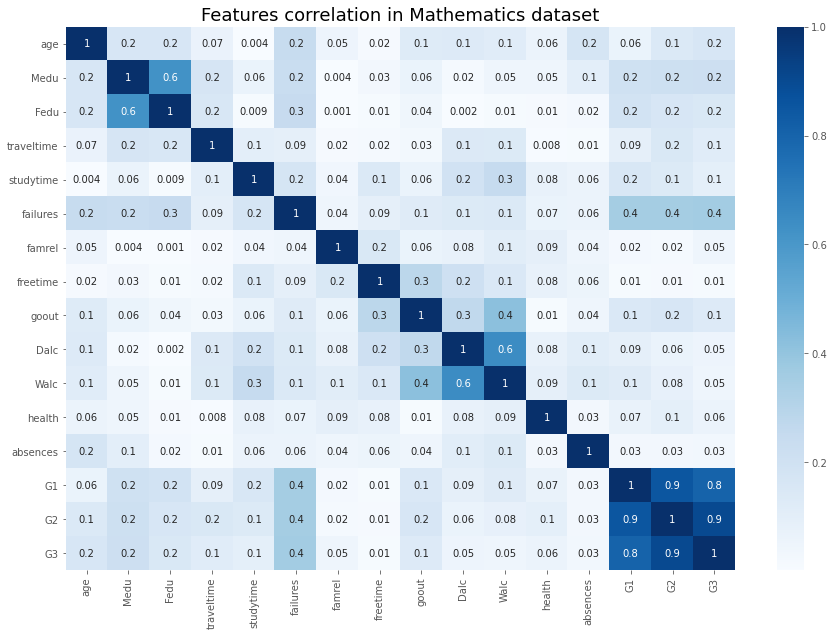

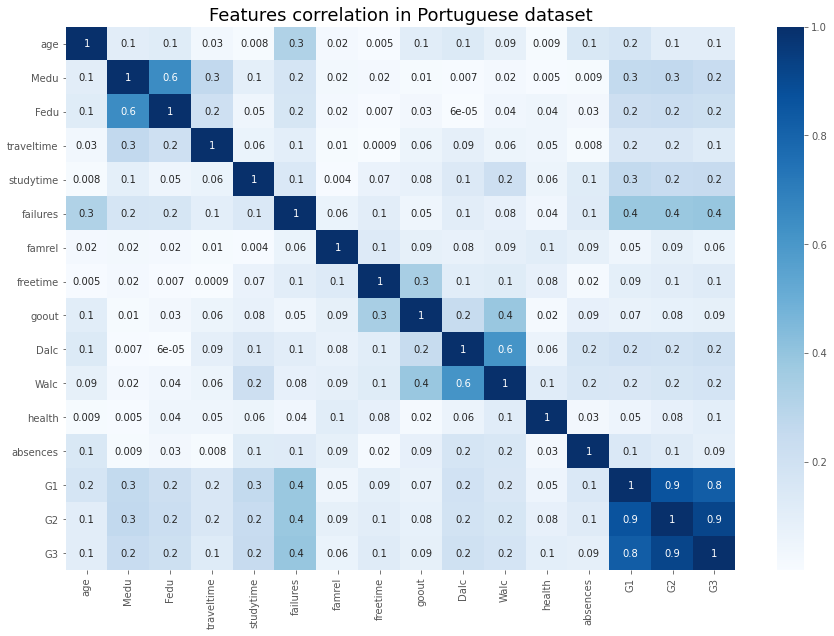

In [72]:
# Features correlation
print_correlation_matrix(data_math.corr().abs(), 'Features correlation in Mathematics dataset')
print_correlation_matrix(data_por.corr().abs(), 'Features correlation in Portuguese dataset')

In [73]:
# Drop low correlated features to target ('G3')
threshold = 0.07
to_drop_math = data_math.corr().abs()['G3'] < threshold
to_drop_port = data_por.corr().abs()['G3'] < threshold
to_drop_math = list((to_drop_math[to_drop_math]).index.values)
to_drop_port = list((to_drop_port[to_drop_port]).index.values)
print("Candidate features to be dropped in Math dataset: ", to_drop_math)
print("Candidate features to be dropped in Portuguese dataset: ", to_drop_port)

Candidate features to be dropped in Math dataset:  ['famrel', 'freetime', 'Dalc', 'Walc', 'health', 'absences']
Candidate features to be dropped in Portuguese dataset:  ['famrel']


In [74]:
data_math = data_math.drop(columns=to_drop_math)
data_por = data_por.drop(columns=to_drop_port)
print("Number of features in Math dataset: ", len(data_math.columns))
print("Number of features in Portuguese dataset: ", len(data_por.columns))

Number of features in Math dataset:  27
Number of features in Portuguese dataset:  32


In [75]:
data_math.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,goout,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,3,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,2,7,8,10


## Classification tasks


1.   **Binary Classification**: *pass* (G3 >= 10), or *fail*
2.   **5-Level Classification** System, based on the Erasmus conversion system
3.   **Regression** on the final grade (G3), ranging from 0 (0%) to 20 (100%)



## Binary Classification

### Data preprocessing and statistics

In [76]:
# Recreate datasets
new_data_math = data_math.copy()
new_data_port = data_por.copy()

# 'G3' becomes a binary label: 0 = fail; 1 = pass
new_data_math['G3'] = np.where(new_data_math['G3'] >= 10, 1, 0)
new_data_port['G3'] = np.where(new_data_port['G3'] >= 10, 1, 0)

In [77]:
new_data_math.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,goout,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,5,6,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,3,5,5,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,2,7,8,1


In [78]:
new_data_port.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,3,4,1,1,3,4,0,11,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,3,3,1,1,3,2,9,11,1
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,3,2,2,3,3,6,12,13,1


**Math dataset statistics**

Pass:  67.09 %
Fail:  32.91 %
Counter({1: 265, 0: 130})


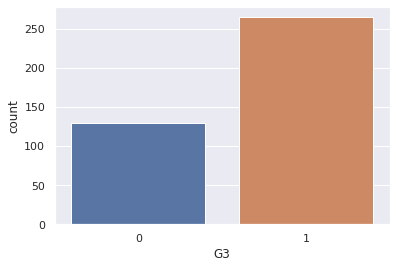

In [79]:
print('Pass: ', round(new_data_math['G3'].value_counts()[1]/len(new_data_math)*100, 2),'%')
print('Fail: ', round(new_data_math['G3'].value_counts()[0]/len(new_data_math) * 100, 2), '%')

counter = Counter(new_data_math['G3'].values)
print(counter)

sns.set(style="darkgrid")
sns.countplot(x="G3", data=new_data_math)

**Portuguese dataset statistics**

Pass:  84.59 %
Fail:  15.41 %
Counter({1: 549, 0: 100})


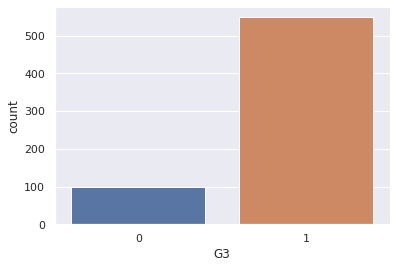

In [80]:
print('Pass: ', round(new_data_port['G3'].value_counts()[1]/len(new_data_port)*100, 2),'%')
print('Fail: ', round(new_data_port['G3'].value_counts()[0]/len(new_data_port) * 100, 2), '%')

counter = Counter(new_data_port['G3'].values)
print(counter)

sns.set(style="darkgrid")
sns.countplot(x="G3", data=new_data_port)

#### Features Encoding

**One Hot Encoding and Custom Binary Encoding**

In [81]:
new_data_math = from_categorical_to_binary_values(new_data_math)
new_data_math = one_hot_encoding_nominal_features(new_data_math)
new_data_port = from_categorical_to_binary_values(new_data_port)
new_data_port = one_hot_encoding_nominal_features(new_data_port)

In [82]:
# Drop columns that can be understood implicitly
new_data_math = new_data_math.drop(columns=['Mjob_other', 'Fjob_other', 'reason_other', 'guardian_other'])
new_data_port = new_data_port.drop(columns=['Mjob_other', 'Fjob_other', 'reason_other', 'guardian_other'])

In [83]:
new_data_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,goout,G1,G2,G3,Mjob_at_home,Mjob_health,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_reputation,guardian_father,guardian_mother
0,1,1,18,1,0,0,4,4,2,2,0,1,0,0,0,1,1,0,0,4,5,6,0,1,0,0,0,0,0,0,1,1,0,0,0,1
1,1,1,17,1,0,1,1,1,1,2,0,0,1,0,0,0,1,1,0,3,5,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,1,1,15,1,1,1,1,1,1,2,3,1,0,1,0,1,1,1,0,2,7,8,1,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,1,15,1,0,1,4,2,1,3,0,0,1,1,1,1,1,1,1,2,15,14,1,0,1,0,0,0,0,1,0,0,1,0,0,1
4,1,1,16,1,0,1,3,3,1,2,0,0,1,1,0,1,1,0,0,2,6,10,1,0,0,0,0,0,0,0,0,0,1,0,1,0


In [84]:
new_data_port.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Mjob_at_home,Mjob_health,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_reputation,guardian_father,guardian_mother
0,1,1,18,1,0,0,4,4,2,2,0,1,0,0,0,1,1,0,0,3,4,1,1,3,4,0,11,1,1,0,0,0,0,0,0,1,1,0,0,0,1
1,1,1,17,1,0,1,1,1,1,2,0,0,1,0,0,0,1,1,0,3,3,1,1,3,2,9,11,1,1,0,0,0,0,0,0,0,1,0,0,1,0
2,1,1,15,1,1,1,1,1,1,2,0,1,0,0,0,1,1,1,0,3,2,2,3,3,6,12,13,1,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,1,15,1,0,1,4,2,1,3,0,0,1,0,1,1,1,1,1,2,2,1,1,5,0,14,14,1,0,1,0,0,0,0,1,0,0,1,0,0,1
4,1,1,16,1,0,1,3,3,1,2,0,0,1,0,0,1,1,0,0,3,2,1,2,5,0,11,13,1,0,0,0,0,0,0,0,0,0,1,0,1,0


In [85]:
print("Number of features in Math dataset: ", len(new_data_math.columns))
print("Number of features in Portuguese dataset: ", len(new_data_port.columns))

Number of features in Math dataset:  36
Number of features in Portuguese dataset:  41


In [86]:
# Create X and y
X_math = new_data_math[new_data_math.columns.difference(['G3'])]
y_math = new_data_math['G3']

X_port = new_data_port[new_data_port.columns.difference(['G3'])]
y_port = new_data_port['G3']

In [87]:
# Create train and test sets
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_math, y_math, test_size=0.2, stratify=y_math, random_state=42) # 'stratify=y' allows to create a test split with an equal percentage
# of positive and negative labels

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_port, y_port, test_size=0.2, stratify=y_port, random_state=42)


In [88]:
# Get rid of dataframe form // da non eseguire 

#X_train_m = X_train_m.values 
#y_train_m = y_train_m.values
#X_test_m = X_test_m.values
#y_test_m = y_test_m.values

#X_train_p = X_train_p.values 
#y_train_p = y_train_p.values
#X_test_p = X_test_p.values
#y_test_p = y_test_p.values

# Verify equal labels distribution in test and train splits
#for y_train, y_test, dataset in zip([y_train_m, y_train_p], [y_test_m, y_test_p], ['Math', 'Portuguese']):
#  _, train_unique_labels = np.unique(y_train, return_counts=True) # returns the number of times each unique value comes up in the input array
#  _, test_unique_labels = np.unique(y_test, return_counts=True)
#  print('Labels distribution in {} dataset:'.format(dataset))
#  labels_percentage = train_unique_labels/len(y_train)
#  print('  Train set: fail = {:.2f}, pass = {:.2f}'.format(labels_percentage[0], labels_percentage[1]))
#  labels_percentage = test_unique_labels/len(y_test)
#  print('  Test set: fail = {:.2f}, pass = {:.2f}'.format(labels_percentage[0], labels_percentage[1]))

#### Bootstrap and Feature Scaling

Use bootstrap to obtain more precise mean and standard deviation values for both datasets.

In [89]:
est_mean_train_m, est_dev_train_m, sem_train_m, err_std_train_m = estimate_mean_stdev_with_bootstrap(X_train_m, n_bootstraps=100)
est_mean_test_m, est_dev_test_m, sem_test_m, err_std_test_m = estimate_mean_stdev_with_bootstrap(X_test_m, n_bootstraps=100)
est_mean_train_p, est_dev_train_p, sem_train_p, err_std_train_p = estimate_mean_stdev_with_bootstrap(X_train_p, n_bootstraps=100, bootstrap_size=700)
est_mean_test_p, est_dev_test_p, sem_test_p, err_std_test_p = estimate_mean_stdev_with_bootstrap(X_test_p, n_bootstraps=100, bootstrap_size=700)

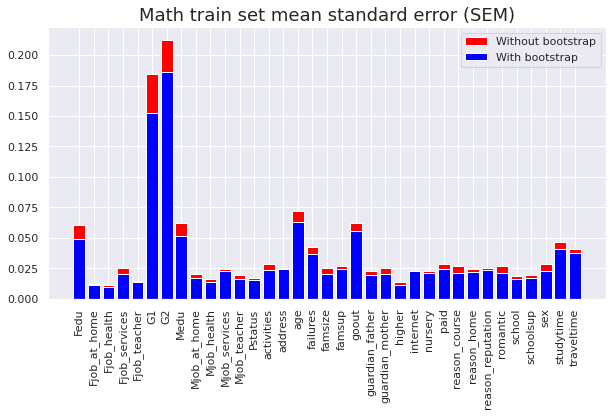

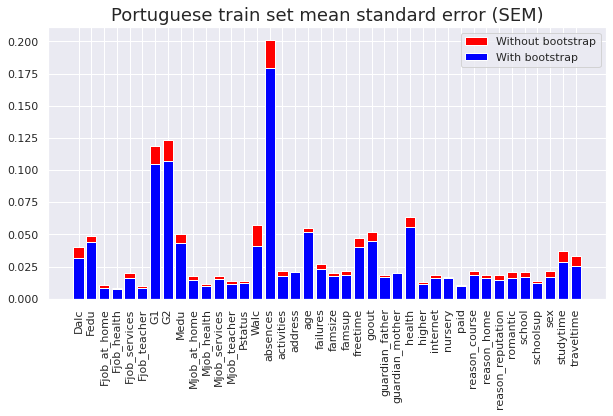

In [90]:
# SEM: measures how far the sample mean of the data is likely to be from the true population mean
plot_df_means(X_train_m.sem(), sem_train_m, 'Without bootstrap','With bootstrap', 'Math train set mean standard error (SEM)')
plot_df_means(X_train_p.sem(), sem_train_p, 'Without bootstrap','With bootstrap', 'Portuguese train set mean standard error (SEM)')

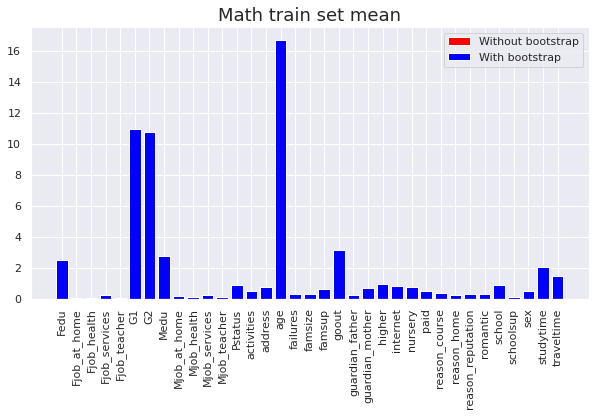

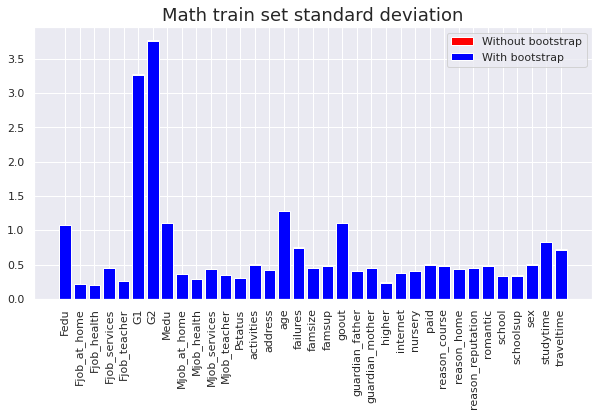

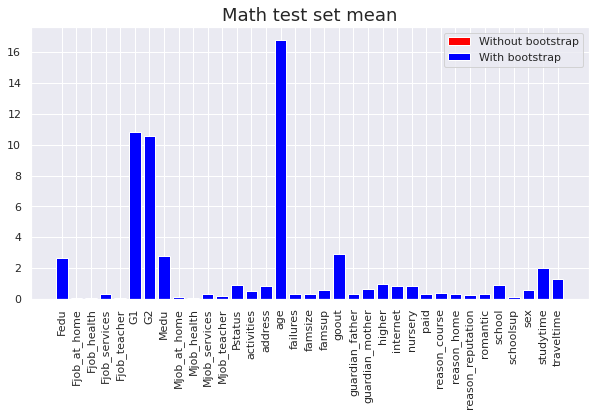

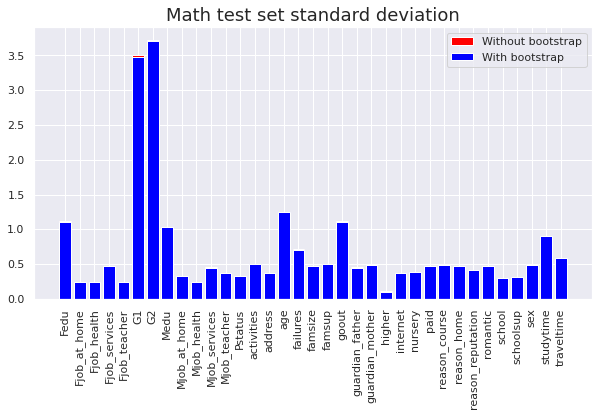

In [91]:
plot_df_means(X_train_m.mean(), est_mean_train_m, 'Without bootstrap','With bootstrap', 'Math train set mean')
plot_df_means(X_train_m.std(), est_dev_train_m, 'Without bootstrap','With bootstrap', 'Math train set standard deviation')
plot_df_means(X_test_m.mean(), est_mean_test_m, 'Without bootstrap','With bootstrap', 'Math test set mean')
plot_df_means(X_test_m.std(), est_dev_test_m, 'Without bootstrap','With bootstrap', 'Math test set standard deviation')

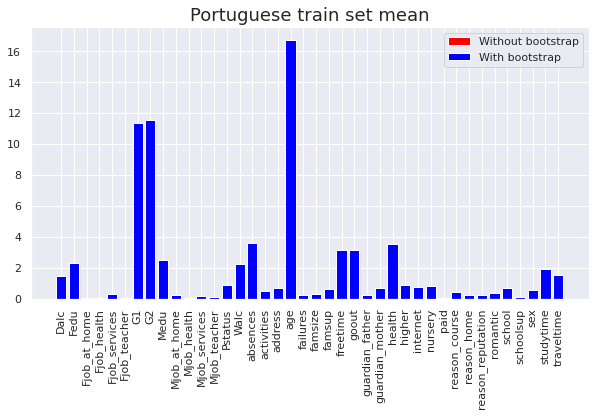

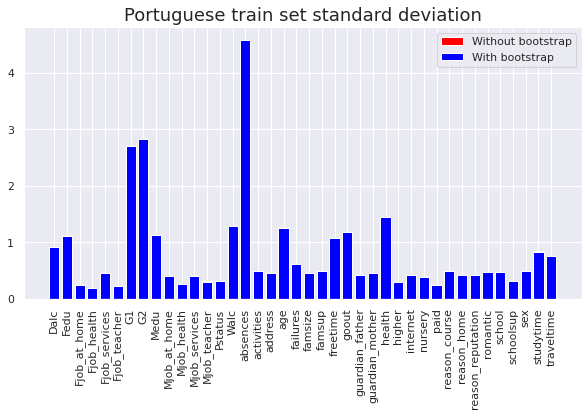

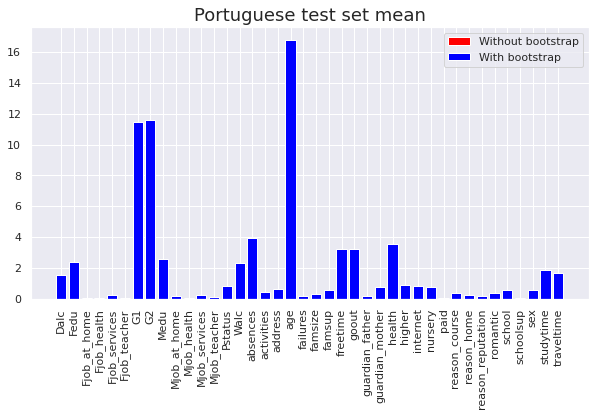

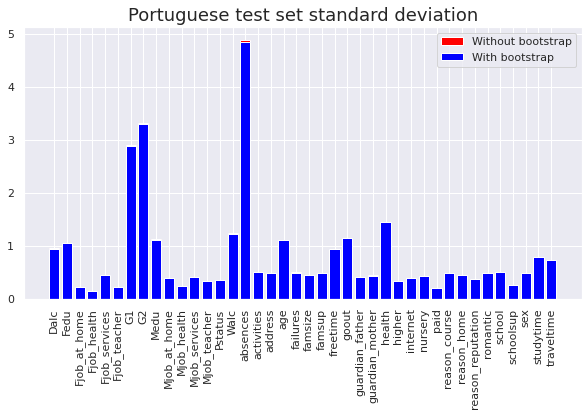

In [92]:
plot_df_means(X_train_p.mean(), est_mean_train_p, 'Without bootstrap','With bootstrap', 'Portuguese train set mean')
plot_df_means(X_train_p.std(), est_dev_train_p, 'Without bootstrap','With bootstrap', 'Portuguese train set standard deviation')
plot_df_means(X_test_p.mean(), est_mean_test_p, 'Without bootstrap','With bootstrap', 'Portuguese test set mean')
plot_df_means(X_test_p.std(), est_dev_test_p, 'Without bootstrap','With bootstrap', 'Portuguese test set standard deviation')

Use obtained mean and standard deviation values to standardize the data (hypotheses: data follow a Gaussian distribution).

In [93]:
X_train_m_std = (X_train_m - est_mean_train_m) / est_dev_train_m
X_test_m_std = (X_test_m - est_mean_test_m) / est_dev_test_m
X_train_p_std = (X_train_p - est_mean_train_p) / est_dev_train_p
X_test_p_std = (X_test_p - est_mean_test_p) / est_dev_test_p

#### Principal Component Analysis (PCA)

Apply PCA on all variables: all categorical attributes have been converted to numerical ones.

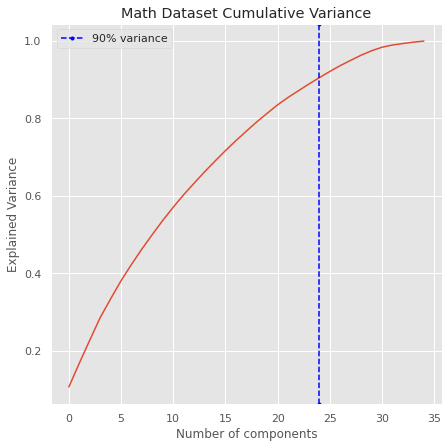

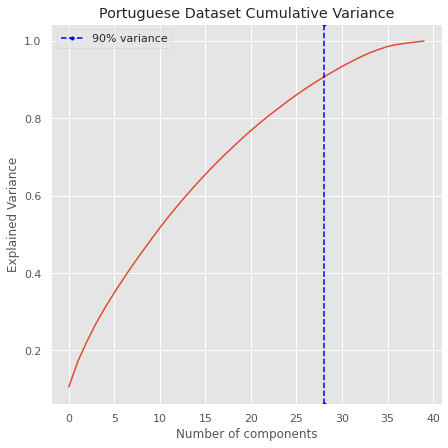

In [94]:
pca_m = PCA()
pca_p = PCA()

X_train_m_pca = pca_m.fit_transform(X_train_m_std)
X_test_m_pca = pca_m.transform(X_test_m_std)

X_train_p_pca = pca_p.fit_transform(X_train_p_std)
X_test_p_pca = pca_p.transform(X_test_p_std)

n_PC_90th_m = plot_explained_variance(pca_m.explained_variance_ratio_, 'Math Dataset Cumulative Variance')
n_PC_90th_p = plot_explained_variance(pca_p.explained_variance_ratio_, 'Portuguese Dataset Cumulative Variance')

Select a number of Principal Components (PCs) that allows to explain **90%** of the variance of the original dataset.

In [95]:
n_PC_90th_m = int(n_PC_90th_m[0])
print("Number of PCs needed to explain 90% of the variance in Math dataset: {:d} out of {:d}".format(n_PC_90th_m, len(pca_m.explained_variance_ratio_)))
n_PC_90th_p = int(n_PC_90th_p[0])
print("Number of PCs needed to explain 90% of the variance in Portuguese dataset: {:d} out of {:d}".format(n_PC_90th_p, len(pca_p.explained_variance_ratio_)))

Number of PCs needed to explain 90% of the variance in Math dataset: 24 out of 35
Number of PCs needed to explain 90% of the variance in Portuguese dataset: 28 out of 40


In [96]:
X_train_m_reduced = pd.DataFrame(X_train_m_pca[:,:n_PC_90th_m], columns=[f'PC{i}' for i in range(n_PC_90th_m)])
X_train_p_reduced = pd.DataFrame(X_train_p_pca[:,:n_PC_90th_p], columns=[f'PC{i}' for i in range(n_PC_90th_p)])

X_test_m_reduced = pd.DataFrame(X_test_m_pca[:,:n_PC_90th_m], columns=[f'PC{i}' for i in range(n_PC_90th_m)])
X_test_p_reduced = pd.DataFrame(X_test_p_pca[:,:n_PC_90th_p], columns=[f'PC{i}' for i in range(n_PC_90th_p)])

In [97]:
X_train_m_reduced.head(3)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,-1.176300,0.168132,-0.947932,-1.775609,2.945906,-1.570548,1.431915,-1.646895,0.202907,1.602071,1.217579,-0.903204,-0.137758,-0.013281,0.524225,-0.908427,-2.012600,0.346554,0.131104,0.751111,0.945713,-1.964548,-0.284301,0.127367
1,0.386633,1.182421,0.607741,2.757661,-0.701221,-1.359808,0.832466,-0.698581,-0.672376,0.354765,-0.054407,0.613610,1.817850,0.476271,-0.844192,0.955316,-0.395942,-0.172763,1.260829,1.782992,0.499532,0.561084,0.468032,0.833136
2,3.229852,-2.004312,0.743813,-0.836670,0.915174,-0.756526,0.694761,-1.109077,-0.128115,-0.397385,0.935907,-0.388856,2.182325,-0.952186,-2.033745,-0.091818,1.508908,1.642719,-0.232168,-0.396259,0.091993,1.796341,0.745013,0.141132


In [98]:
X_train_p_reduced.head(3)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
0,-2.497080,1.046444,0.246599,1.066232,-0.095667,0.010403,-1.616314,2.519501,0.661873,1.121244,0.083130,-0.897579,-0.369744,0.218374,-0.349939,-0.209360,0.199715,-0.001031,-1.110451,0.753643,-0.795260,0.024386,0.109950,-0.580230,0.135292,-0.328790,-0.395519,-1.006417
1,0.256227,-1.480845,-1.831382,-0.875272,0.340015,2.133245,0.315140,0.247616,-0.867991,-0.726658,-1.316164,0.318446,0.090909,1.171259,0.149129,0.355473,-0.227379,1.049262,-1.141251,1.177115,-0.736427,-2.071479,-0.315243,0.381377,1.091430,0.302888,-0.189423,1.136944
2,2.415638,-1.286446,1.694270,1.874069,-0.939132,0.831953,0.021136,-1.175636,0.234625,-0.440584,-0.663335,0.375952,-0.082912,-0.599761,-1.275397,0.809123,-0.464145,-0.951945,-0.912575,0.199447,0.039121,-1.385767,-0.487255,1.233515,-0.190609,0.358582,0.741186,-0.779703


#### Dataset Oversampling: SMOTE Algorithm (Synthetic Minority Oversampling Technique)
Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [99]:
sampler = SMOTE(random_state=0)
print("###### Math dataset ######")
print(Counter(y_train_m))
X_smote_m, y_smote_m = sampler.fit_resample(X_train_m_reduced, y_train_m)
print(Counter(y_smote_m))

print("###### Portuguese dataset ######")
print(Counter(y_train_p))
X_smote_p, y_smote_p = sampler.fit_resample(X_train_p_reduced, y_train_p)
print(Counter(y_smote_p))

###### Math dataset ######
Counter({1: 212, 0: 104})
Counter({0: 212, 1: 212})
###### Portuguese dataset ######
Counter({1: 439, 0: 80})
Counter({1: 439, 0: 439})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Classification

Proposed algorithms:
1. Logistic Regression
2. K-NN
3. SVM
4. Decision Tree
5. Random Forest

The classification algorithms will be trained on both oversampled and not oversampled sets and the obtained results will be compared.

In [100]:
def classification(X_train, y_train, X_test, y_test, clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)

In [101]:
def print_classification_report(X_train, y_train, X_test, y_test, clf):
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)


#### Logistic Regression

##### PCA-reduced dataset

######### Math dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.5s finished


{'C': 0.1}
accuracy Math:
0.8481012658227848
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        26
           1       0.89      0.89      0.89        53

    accuracy                           0.85        79
   macro avg       0.83      0.83      0.83        79
weighted avg       0.85      0.85      0.85        79



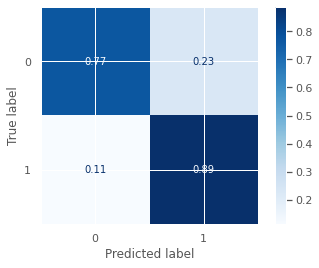

In [102]:
# Parameters Tuning
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
LR_acc= np.zeros((1,4))

print("######### Math dataset #########")
clf_m = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_m = GridSearchCV(clf_m, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_m.fit(X_train_m_reduced, y_train_m).score(X_test_m_reduced, y_test_m)

LR_acc[0,0] = acc

print(clf_m.best_params_)
print("accuracy Math:")
print(acc)
print_classification_report(X_train_m_reduced, y_train_m, X_test_m_reduced, y_test_m, clf_m)

######### Portuguese dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.4s finished


{'C': 10}
accuracy Por:
0.9153846153846154
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        20
           1       0.93      0.97      0.95       110

    accuracy                           0.92       130
   macro avg       0.87      0.79      0.82       130
weighted avg       0.91      0.92      0.91       130



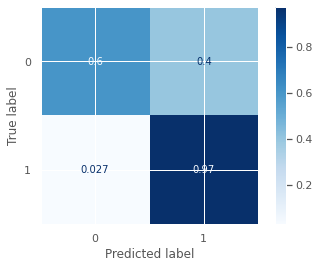

In [103]:
print("######### Portuguese dataset #########")
clf_p = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_p = GridSearchCV(clf_p, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_p.fit(X_train_p_reduced, y_train_p).score(X_test_p_reduced, y_test_p)

LR_acc[0,2] = acc
print(clf_p.best_params_)
print("accuracy Por:")
print(acc)
print_classification_report(X_train_p_reduced, y_train_p, X_test_p_reduced, y_test_p, clf_p)

##### PCA-reduced dataset and oversampled train set

######### Math dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


{'C': 1}
accuracy Math smote:
0.8607594936708861
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        26
           1       0.92      0.87      0.89        53

    accuracy                           0.86        79
   macro avg       0.84      0.86      0.85        79
weighted avg       0.87      0.86      0.86        79



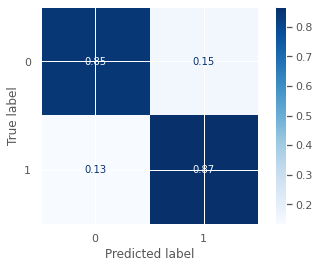

In [104]:
# Parameters Tuning
print("######### Math dataset #########")
clf_m = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clf_m = GridSearchCV(clf_m, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_m.fit(X_smote_m, y_smote_m).score(X_test_m_reduced, y_test_m)

LR_acc[0,1] = acc
print(clf_m.best_params_)
print("accuracy Math smote:")
print(acc)
print_classification_report(X_smote_m, y_smote_m, X_test_m_reduced, y_test_m, clf_m)

######### Portuguese dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.3s finished


{'C': 10}
accuracy Por smote:
0.8769230769230769
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        20
           1       0.94      0.92      0.93       110

    accuracy                           0.88       130
   macro avg       0.76      0.78      0.77       130
weighted avg       0.88      0.88      0.88       130



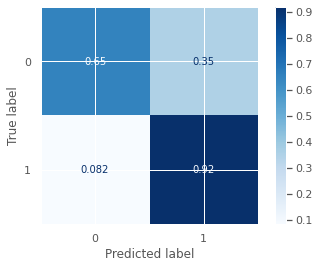

In [105]:
print("######### Portuguese dataset #########")
clf_p = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_p = GridSearchCV(clf_p, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_p.fit(X_smote_p, y_smote_p).score(X_test_p_reduced, y_test_p)

LR_acc[0,3] = acc
print(clf_p.best_params_)
print("accuracy Por smote:")
print(acc)
print_classification_report(X_smote_p, y_smote_p, X_test_p_reduced, y_test_p, clf_p)

In [106]:
LR_scores = pd.DataFrame(np.round(LR_acc, decimals = 2), columns=['Math','Math_smote', 'Portoguese','Portoguese_smote'], index=['Logistic Regression'])
LR_scores 

,Math,Math_smote,Portoguese,Portoguese_smote
Logistic Regression,0.85,0.86,0.92,0.88


#### K-Nearest Neighbors

##### PCA-reduced dataset

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    1.4s finished


{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
accuracy Math: 
0.7721518987341772
              precision    recall  f1-score   support

           0       0.83      0.38      0.53        26
           1       0.76      0.96      0.85        53

    accuracy                           0.77        79
   macro avg       0.80      0.67      0.69        79
weighted avg       0.78      0.77      0.74        79



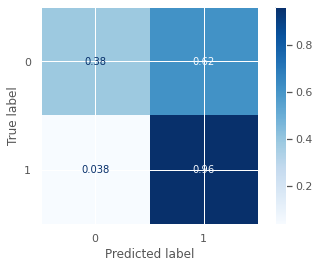

In [107]:
params_grid = {'n_neighbors': np.arange(1,22,2).tolist(), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
KNN_acc = np.zeros((1,4))

clf_m = KNeighborsClassifier()
clf_m = GridSearchCV(clf_m, param_grid = params_grid, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc = clf_m.fit(X_train_m_reduced, y_train_m).score(X_test_m_reduced, y_test_m)
KNN_acc[0,0] = acc
print(clf_m.best_params_)
print('accuracy Math: ')
print(acc)
print_classification_report(X_train_m_reduced, y_train_m, X_test_m_reduced, y_test_m, clf_m)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    1.6s finished


{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
accuracy Por: 
0.8615384615384616
              precision    recall  f1-score   support

           0       0.62      0.25      0.36        20
           1       0.88      0.97      0.92       110

    accuracy                           0.86       130
   macro avg       0.75      0.61      0.64       130
weighted avg       0.84      0.86      0.84       130



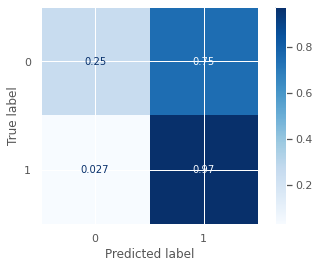

In [108]:
clf_p = KNeighborsClassifier()
clf_p = GridSearchCV(clf_p, param_grid = params_grid, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc = clf_p.fit(X_train_p_reduced, y_train_p).score(X_test_p_reduced, y_test_p)
KNN_acc[0,2] = acc

print(clf_p.best_params_)
print('accuracy Por: ')
print(acc)
print_classification_report(X_train_p_reduced, y_train_p, X_test_p_reduced, y_test_p, clf_p)

##### PCA-reduced dataset and oversampled train set

In [ ]:
params_grid = {'n_neighbors': np.arange(1,22,2).tolist(), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    1.0s finished


{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
accuracy Math smote: 
0.7341772151898734
              precision    recall  f1-score   support

           0       0.60      0.58      0.59        26
           1       0.80      0.81      0.80        53

    accuracy                           0.73        79
   macro avg       0.70      0.69      0.70        79
weighted avg       0.73      0.73      0.73        79



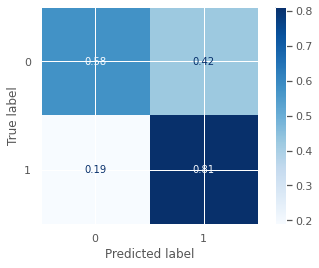

In [109]:
clf_m = KNeighborsClassifier()
clf_m = GridSearchCV(clf_m, param_grid = params_grid, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc = clf_m.fit(X_smote_m, y_smote_m).score(X_test_m_reduced, y_test_m)
KNN_acc[0,1] = acc
print(clf_m.best_params_)
print('accuracy Math smote: ')
print(acc)
print_classification_report(X_smote_m, y_smote_m, X_test_m_reduced, y_test_m, clf_m)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    2.3s finished


{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
accuracy Por smote: 
0.7846153846153846
              precision    recall  f1-score   support

           0       0.35      0.45      0.39        20
           1       0.89      0.85      0.87       110

    accuracy                           0.78       130
   macro avg       0.62      0.65      0.63       130
weighted avg       0.81      0.78      0.80       130



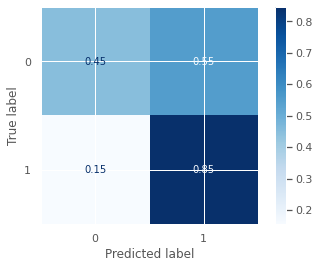

In [110]:
clf_p = KNeighborsClassifier()
clf_p = GridSearchCV(clf_p, param_grid = params_grid, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc = clf_p.fit(X_smote_p, y_smote_p).score(X_test_p_reduced, y_test_p)
KNN_acc[0,3] = acc
print(clf_p.best_params_)

print('accuracy Por smote: ')
print(acc)
print_classification_report(X_smote_p, y_smote_p, X_test_p_reduced, y_test_p, clf_p)

In [111]:
KNN_scores = pd.DataFrame(np.round(KNN_acc, decimals = 2), columns=['Math','Math_smote', 'Portoguese','Portoguese_smote'], index=['KNN'])
KNN_scores 

,Math,Math_smote,Portoguese,Portoguese_smote
KNN,0.77,0.73,0.86,0.78


#### Support Vector Machines

##### PCA-reduced dataset

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    2.0s finished


######### Linear kernel param (Math) #########
{'C': 0.01}
accuracy: 
0.8481012658227848
              precision    recall  f1-score   support

           0       0.85      0.65      0.74        26
           1       0.85      0.94      0.89        53

    accuracy                           0.85        79
   macro avg       0.85      0.80      0.82        79
weighted avg       0.85      0.85      0.84        79

######### RBF kernel param (Math) #########
{'C': 1000, 'gamma': 1e-05}
accuracy: 
0.8227848101265823
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        26
           1       0.85      0.89      0.87        53

    accuracy                           0.82        79
   macro avg       0.80      0.79      0.80        79
weighted avg       0.82      0.82      0.82        79



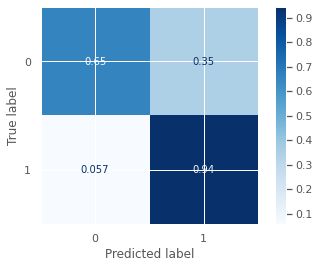

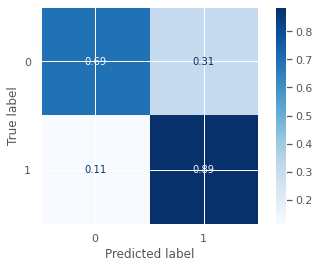

In [112]:
params_grid_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
params_grid_rbf    = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [10**(-7), 10**(-5), 10**(-3), 10**(-1), 0.5, 1, 10, 100]}

SVM_acc_linear = np.zeros((1,4))
SVM_acc_rbf = np.zeros((1,4))

clf_m_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_m_linear = GridSearchCV(clf_m_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_m_linear.fit(X_train_m_reduced, y_train_m).score(X_test_m_reduced, y_test_m)

SVM_acc_linear[0,0] = acc_linear

clf_m_rbf = SVC(kernel = 'rbf')
clf_m_rbf = GridSearchCV(clf_m_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_m_rbf.fit(X_train_m_reduced, y_train_m).score(X_test_m_reduced, y_test_m)

SVM_acc_rbf[0,0] = acc_rbf

print("######### Linear kernel param (Math) #########")
print(clf_m_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print_classification_report(X_train_m_reduced, y_train_m, X_test_m_reduced, y_test_m, clf_m_linear)



print("######### RBF kernel param (Math) #########")
print(clf_m_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print_classification_report(X_train_m_reduced, y_train_m, X_test_m_reduced, y_test_m, clf_m_rbf)


         PC0       PC1       PC2  ...      PC21      PC22      PC23
0  -0.928474  0.453412  0.990402  ...  1.162614  0.281716  0.313862
1   1.354603 -0.994148  1.087262  ... -0.077215 -0.389402  0.396964
2   0.332339  0.302395  0.421286  ...  0.573364 -0.065228  0.362101
3   0.385626  0.697069  0.980453  ...  0.407793 -0.330140 -1.616010
4  -1.309064  2.864507  1.382959  ...  0.865970  0.379066 -0.301972
..       ...       ...       ...  ...       ...       ...       ...
74  0.648563  1.541776  0.497766  ...  0.015730  0.393271 -0.084065
75  0.129615 -0.341124 -0.483579  ...  0.316775 -1.526992 -0.853366
76  0.164101  1.936032  0.380757  ... -0.890822 -0.955840 -0.538699
77 -0.812758  0.050475 -0.176698  ... -1.240845 -0.698870 -0.368841
78 -0.643902  1.466084 -0.553484  ...  2.037978 -0.343018  0.199012

[79 rows x 24 columns]
n_features:  24
         PC0       PC1       PC2  ...      PC21      PC22      PC23
0  -0.928474  0.453412  0.990402  ...  1.162614  0.281716  0.313862
1   1.35

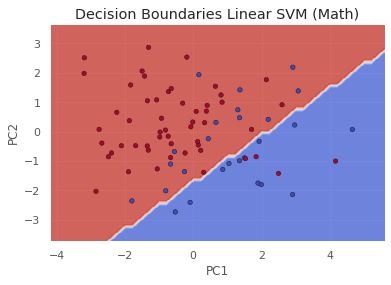

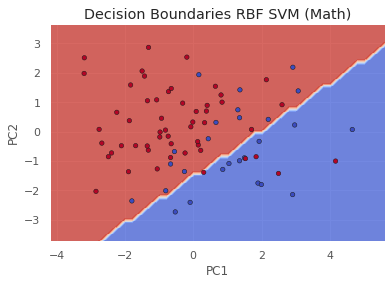

In [113]:
decision_boundaries(X_test_m_reduced, y_test_m, 'Decision Boundaries Linear SVM (Math)', clf_m_linear)
decision_boundaries(X_test_m_reduced, y_test_m, 'Decision Boundaries RBF SVM (Math)', clf_m_rbf)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    3.4s finished


######### Linear kernel param (Por) #########
{'C': 10}
accuracy: 
0.8923076923076924
              precision    recall  f1-score   support

           0       0.75      0.45      0.56        20
           1       0.91      0.97      0.94       110

    accuracy                           0.89       130
   macro avg       0.83      0.71      0.75       130
weighted avg       0.88      0.89      0.88       130

######### RBF kernel param (Por) #########
{'C': 100, 'gamma': 0.001}
accuracy: 
0.9076923076923077
              precision    recall  f1-score   support

           0       0.79      0.55      0.65        20
           1       0.92      0.97      0.95       110

    accuracy                           0.91       130
   macro avg       0.85      0.76      0.80       130
weighted avg       0.90      0.91      0.90       130



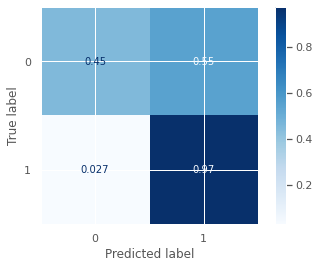

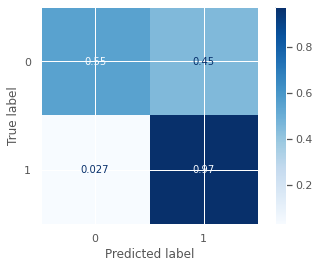

In [114]:
clf_p_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_p_linear = GridSearchCV(clf_p_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_p_linear.fit(X_train_p_reduced, y_train_p).score(X_test_p_reduced, y_test_p)


SVM_acc_linear[0,2] = acc_linear

clf_p_rbf = SVC(kernel = 'rbf')
clf_p_rbf = GridSearchCV(clf_p_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_p_rbf.fit(X_train_p_reduced, y_train_p).score(X_test_p_reduced, y_test_p)



SVM_acc_rbf[0,2] = acc_rbf

print("######### Linear kernel param (Por) #########")
print(clf_p_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print_classification_report(X_train_p_reduced, y_train_m, X_test_p_reduced, y_test_p, clf_p_linear)


print("######### RBF kernel param (Por) #########")
print(clf_p_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print_classification_report(X_train_p_reduced, y_train_p, X_test_p_reduced, y_test_p, clf_p_rbf)

          PC0       PC1       PC2  ...      PC25      PC26      PC27
0   -2.351152  0.767602 -1.249739  ...  0.440279  0.044946  0.115473
1   -0.636247 -0.419245 -1.106373  ...  0.063224  0.366199 -0.178266
2   -1.648628 -0.043409  1.613733  ...  0.616674 -0.370487 -0.602443
3    0.622044 -2.537098 -0.592191  ...  0.156079  0.107048 -1.260588
4    3.273070  2.323753 -0.494436  ...  0.044540 -0.316574  1.091027
..        ...       ...       ...  ...       ...       ...       ...
125  0.065740 -1.743625  2.035358  ... -0.114796  0.405297 -1.733561
126  0.428561 -0.621176 -0.710574  ... -0.690020  0.227419 -0.093982
127 -0.943328 -0.707172 -0.529958  ...  0.432828  0.127182 -0.827821
128 -1.930303  1.293948 -0.202136  ... -0.223965 -0.072090  0.670304
129  3.005896 -0.899575 -0.797418  ... -1.157272 -0.154235  0.526698

[130 rows x 28 columns]
n_features:  28
          PC0       PC1       PC2  ...      PC25      PC26      PC27
0   -2.351152  0.767602 -1.249739  ...  0.440279  0.044946  0.

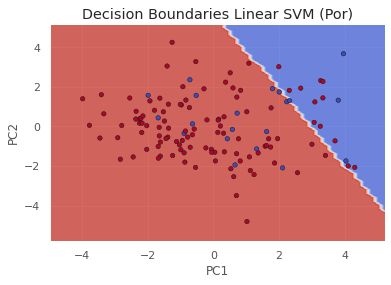

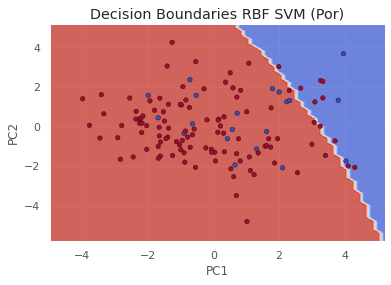

In [115]:
decision_boundaries(X_test_p_reduced, y_test_p, 'Decision Boundaries Linear SVM (Por)', clf_p_linear)
decision_boundaries(X_test_p_reduced, y_test_p, 'Decision Boundaries RBF SVM (Por)', clf_p_rbf)

##### PCA-reduced dataset and oversampled train set

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   37.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    2.3s finished


######### Linear kernel param (Math smote)#########
{'C': 0.1}
accuracy: 
0.8481012658227848
              precision    recall  f1-score   support

           0       0.73      0.85      0.79        26
           1       0.92      0.85      0.88        53

    accuracy                           0.85        79
   macro avg       0.83      0.85      0.83        79
weighted avg       0.86      0.85      0.85        79

######### RBF kernel param (Math smote)#########
{'C': 1000, 'gamma': 0.001}
accuracy: 
0.8481012658227848
              precision    recall  f1-score   support

           0       0.75      0.81      0.78        26
           1       0.90      0.87      0.88        53

    accuracy                           0.85        79
   macro avg       0.83      0.84      0.83        79
weighted avg       0.85      0.85      0.85        79



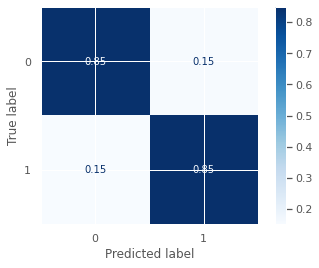

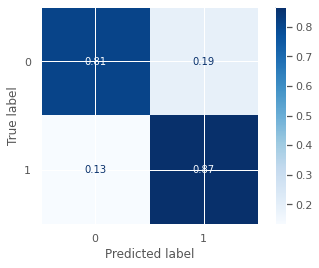

In [116]:
params_grid_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
params_grid_rbf    = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [10**(-7), 10**(-5), 10**(-3), 10**(-1), 0.5, 1, 10, 100]}

clf_m_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_m_linear = GridSearchCV(clf_m_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_m_linear.fit(X_smote_m, y_smote_m).score(X_test_m_reduced, y_test_m)

SVM_acc_linear[0,1] = acc_linear

clf_m_rbf = SVC(kernel = 'rbf')
clf_m_rbf = GridSearchCV(clf_m_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_m_rbf.fit(X_smote_m, y_smote_m).score(X_test_m_reduced, y_test_m)

SVM_acc_rbf[0,1] = acc_rbf

print("######### Linear kernel param (Math smote)#########")
print(clf_m_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print_classification_report(X_smote_m, y_smote_m, X_test_m_reduced, y_test_m, clf_m_linear)

print("######### RBF kernel param (Math smote)#########")
print(clf_m_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print_classification_report(X_smote_m, y_smote_m, X_test_m_reduced, y_test_m, clf_m_rbf)

         PC0       PC1       PC2  ...      PC21      PC22      PC23
0  -0.928474  0.453412  0.990402  ...  1.162614  0.281716  0.313862
1   1.354603 -0.994148  1.087262  ... -0.077215 -0.389402  0.396964
2   0.332339  0.302395  0.421286  ...  0.573364 -0.065228  0.362101
3   0.385626  0.697069  0.980453  ...  0.407793 -0.330140 -1.616010
4  -1.309064  2.864507  1.382959  ...  0.865970  0.379066 -0.301972
..       ...       ...       ...  ...       ...       ...       ...
74  0.648563  1.541776  0.497766  ...  0.015730  0.393271 -0.084065
75  0.129615 -0.341124 -0.483579  ...  0.316775 -1.526992 -0.853366
76  0.164101  1.936032  0.380757  ... -0.890822 -0.955840 -0.538699
77 -0.812758  0.050475 -0.176698  ... -1.240845 -0.698870 -0.368841
78 -0.643902  1.466084 -0.553484  ...  2.037978 -0.343018  0.199012

[79 rows x 24 columns]
n_features:  24
         PC0       PC1       PC2  ...      PC21      PC22      PC23
0  -0.928474  0.453412  0.990402  ...  1.162614  0.281716  0.313862
1   1.35

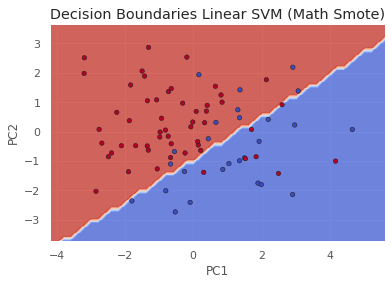

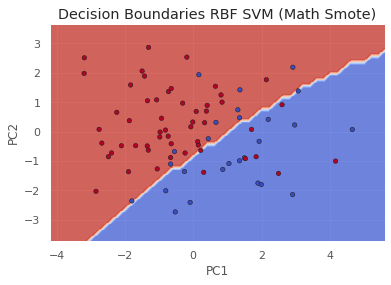

In [117]:
decision_boundaries(X_test_m_reduced, y_test_m, 'Decision Boundaries Linear SVM (Math Smote)', clf_m_linear)
decision_boundaries(X_test_m_reduced, y_test_m, 'Decision Boundaries RBF SVM (Math Smote)', clf_m_rbf)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   32.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    8.5s finished


######### Linear kernel param (Por smote)#########
{'C': 10}
accuracy: 
0.8769230769230769
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        20
           1       0.94      0.92      0.93       110

    accuracy                           0.88       130
   macro avg       0.76      0.78      0.77       130
weighted avg       0.88      0.88      0.88       130

######### RBF kernel param (Por smote)#########
{'C': 10, 'gamma': 0.1}
accuracy: 
0.8384615384615385
              precision    recall  f1-score   support

           0       0.33      0.05      0.09        20
           1       0.85      0.98      0.91       110

    accuracy                           0.84       130
   macro avg       0.59      0.52      0.50       130
weighted avg       0.77      0.84      0.78       130



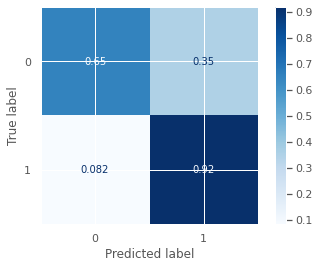

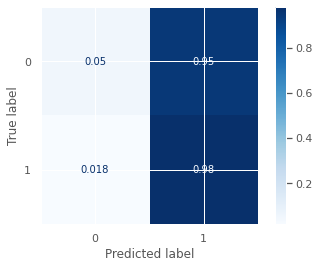

In [118]:
clf_p_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_p_linear = GridSearchCV(clf_p_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_p_linear.fit(X_smote_p, y_smote_p).score(X_test_p_reduced, y_test_p)

SVM_acc_linear[0,3] = acc_linear

clf_p_rbf = SVC(kernel = 'rbf')
clf_p_rbf = GridSearchCV(clf_p_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_p_rbf.fit(X_smote_p, y_smote_p).score(X_test_p_reduced, y_test_p)

SVM_acc_rbf[0,3] = acc_rbf 

print("######### Linear kernel param (Por smote)#########")
print(clf_p_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print_classification_report(X_smote_p, y_smote_p, X_test_p_reduced, y_test_p, clf_p_linear)

print("######### RBF kernel param (Por smote)#########")
print(clf_p_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print_classification_report(X_smote_p, y_smote_p, X_test_p_reduced, y_test_p, clf_p_rbf)

          PC0       PC1       PC2  ...      PC25      PC26      PC27
0   -2.351152  0.767602 -1.249739  ...  0.440279  0.044946  0.115473
1   -0.636247 -0.419245 -1.106373  ...  0.063224  0.366199 -0.178266
2   -1.648628 -0.043409  1.613733  ...  0.616674 -0.370487 -0.602443
3    0.622044 -2.537098 -0.592191  ...  0.156079  0.107048 -1.260588
4    3.273070  2.323753 -0.494436  ...  0.044540 -0.316574  1.091027
..        ...       ...       ...  ...       ...       ...       ...
125  0.065740 -1.743625  2.035358  ... -0.114796  0.405297 -1.733561
126  0.428561 -0.621176 -0.710574  ... -0.690020  0.227419 -0.093982
127 -0.943328 -0.707172 -0.529958  ...  0.432828  0.127182 -0.827821
128 -1.930303  1.293948 -0.202136  ... -0.223965 -0.072090  0.670304
129  3.005896 -0.899575 -0.797418  ... -1.157272 -0.154235  0.526698

[130 rows x 28 columns]
n_features:  28
          PC0       PC1       PC2  ...      PC25      PC26      PC27
0   -2.351152  0.767602 -1.249739  ...  0.440279  0.044946  0.

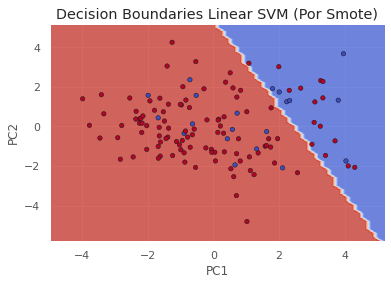

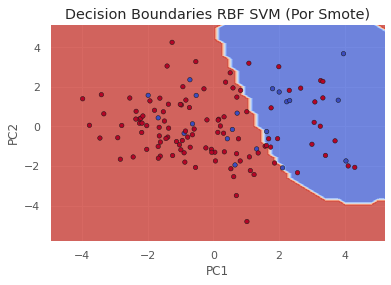

In [119]:
decision_boundaries(X_test_p_reduced, y_test_p, 'Decision Boundaries Linear SVM (Por Smote)', clf_p_linear)
decision_boundaries(X_test_p_reduced, y_test_p, 'Decision Boundaries RBF SVM (Por Smote)', clf_p_rbf)

In [120]:
SVM_scores_linear = pd.DataFrame(np.round(SVM_acc_linear, 2), columns=['Math','Math_smote', 'Portoguese','Portoguese_smote'], index=['SVM linear'])
SVM_scores_rbf = pd.DataFrame(np.round(SVM_acc_rbf, 2), columns=['Math','Math_smote', 'Portoguese','Portoguese_smote'], index=['SVM rbf'])
SVM_scores_linear

,Math,Math_smote,Portoguese,Portoguese_smote
SVM linear,0.85,0.85,0.89,0.88


#### Decision Tree

##### PCA-reduced dataset

######### Math dataset #########
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   25.5s finished


{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.759493670886076
              precision    recall  f1-score   support

           0       0.68      0.50      0.58        26
           1       0.78      0.89      0.83        53

    accuracy                           0.76        79
   macro avg       0.73      0.69      0.70        79
weighted avg       0.75      0.76      0.75        79



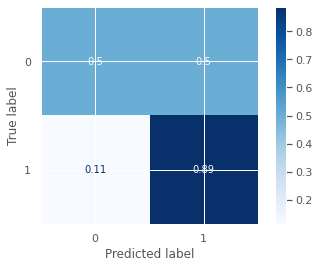

In [121]:
# Parameters Tuning
params_grid = {'criterion': ['gini','entropy'], 'max_depth': np.arange(1,22,5).tolist(),'min_samples_split': np.arange(1,11).tolist(), 
               'min_samples_leaf': np.arange(1,11).tolist()}
DT_acc = np.zeros((1,4))
print("######### Math dataset #########")
clf_m = DecisionTreeClassifier()
clf_m = GridSearchCV(clf_m, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_m.fit(X_train_m_reduced, y_train_m).score(X_test_m_reduced, y_test_m)

DT_acc[0,0] = acc
print(clf_m.best_params_)
print(acc)
print_classification_report(X_train_m_reduced, y_train_m, X_test_m_reduced, y_test_m, clf_m)

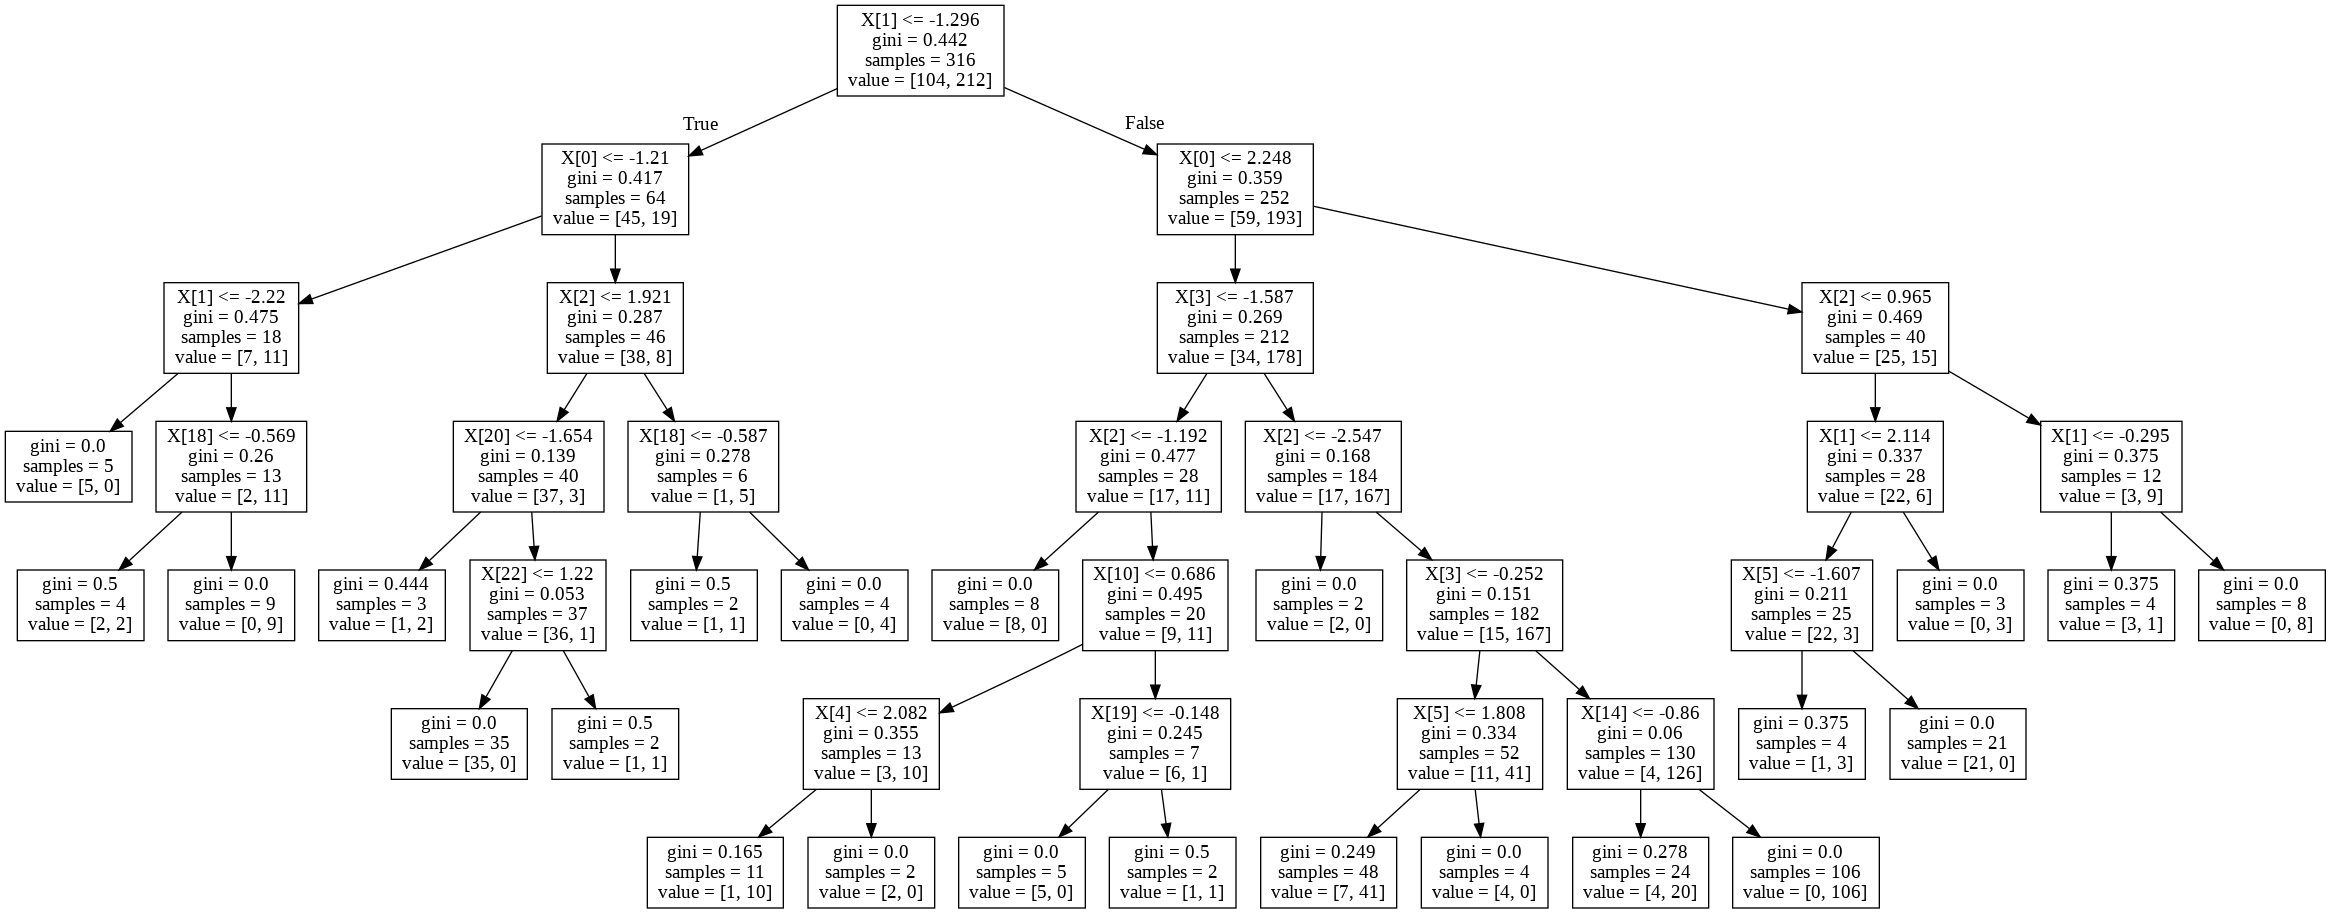

In [122]:
# Print example of DT
dot_data = StringIO() 
tree.export_graphviz(clf_m.best_estimator_, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

######### Portuguese dataset #########
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 484 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 2884 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 4997 out of 5000 | elapsed:   33.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   33.9s finished


{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.7846153846153846
              precision    recall  f1-score   support

           0       0.21      0.15      0.18        20
           1       0.85      0.90      0.88       110

    accuracy                           0.78       130
   macro avg       0.53      0.53      0.53       130
weighted avg       0.76      0.78      0.77       130



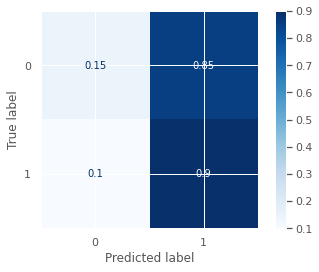

In [123]:
print("######### Portuguese dataset #########")
clf_p = DecisionTreeClassifier()
clf_p = GridSearchCV(clf_p, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_p.fit(X_train_p_reduced, y_train_p).score(X_test_p_reduced, y_test_p)
DT_acc[0,2] = acc

print(clf_p.best_params_)
print(acc)
print_classification_report(X_train_p_reduced, y_train_p, X_test_p_reduced, y_test_p, clf_p)

##### PCA-reduced dataset and oversampled train set

######### Math dataset #########
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   21.2s finished


{'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 3, 'min_samples_split': 6}
0.7215189873417721
              precision    recall  f1-score   support

           0       0.57      0.65      0.61        26
           1       0.82      0.75      0.78        53

    accuracy                           0.72        79
   macro avg       0.69      0.70      0.70        79
weighted avg       0.73      0.72      0.73        79



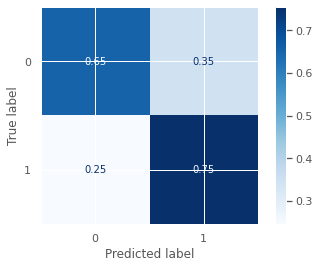

In [124]:
# Parameters Tuning
print("######### Math dataset #########")
clf_m = DecisionTreeClassifier()
clf_m = GridSearchCV(clf_m, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_m.fit(X_smote_m, y_smote_m).score(X_test_m_reduced, y_test_m)

DT_acc[0,1] = acc
print(clf_m.best_params_)
print(acc)
print_classification_report(X_smote_m, y_smote_m, X_test_m_reduced, y_test_m, clf_m)

######### Portuguese dataset #########
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   47.2s finished


{'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 3, 'min_samples_split': 2}
0.7769230769230769
              precision    recall  f1-score   support

           0       0.32      0.40      0.36        20
           1       0.89      0.85      0.87       110

    accuracy                           0.78       130
   macro avg       0.60      0.62      0.61       130
weighted avg       0.80      0.78      0.79       130



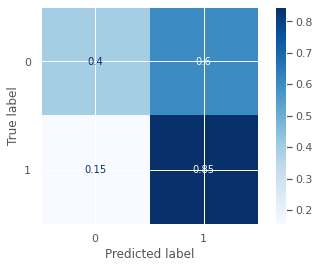

In [125]:
print("######### Portuguese dataset #########")
clf_p = DecisionTreeClassifier()
clf_p = GridSearchCV(clf_p, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_p.fit(X_smote_p, y_smote_p).score(X_test_p_reduced, y_test_p)

DT_acc[0,3] = acc
print(clf_p.best_params_)
print(acc)
print_classification_report(X_smote_p, y_smote_p, X_test_p_reduced, y_test_p, clf_p)

In [126]:
DT_scores = pd.DataFrame(np.round(DT_acc, 2), columns=['Math','Math_smote', 'Portoguese','Portoguese_smote'], index=['Decision Tree'])
DT_scores

,Math,Math_smote,Portoguese,Portoguese_smote
Decision Tree,0.76,0.72,0.78,0.78


#### Random Forest

##### PCA-reduced dataset

######### Math dataset #########
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   29.4s finished


{'criterion': 'gini', 'n_estimators': 901}
0.7974683544303798
              precision    recall  f1-score   support

           0       0.81      0.50      0.62        26
           1       0.79      0.94      0.86        53

    accuracy                           0.80        79
   macro avg       0.80      0.72      0.74        79
weighted avg       0.80      0.80      0.78        79



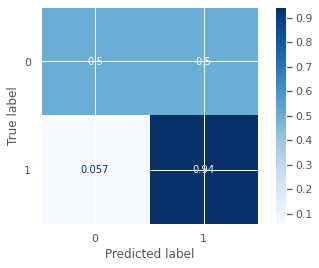

In [127]:
# Parameters Tuning
params_grid = {'n_estimators': np.arange(1,1001,300).tolist(), 'criterion': ['gini','entropy']}
RF_acc = np.zeros((1,4))

print("######### Math dataset #########")
clf_m = RandomForestClassifier(max_features='sqrt', random_state=0)
clf_m = GridSearchCV(clf_m, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_m.fit(X_train_m_reduced, y_train_m).score(X_test_m_reduced, y_test_m)

RF_acc[0,0] = acc
print(clf_m.best_params_)
print(acc)
print_classification_report(X_train_m_reduced, y_train_m, X_test_m_reduced, y_test_m, clf_m)

######### Portuguese dataset #########
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   37.6s finished


{'criterion': 'gini', 'n_estimators': 301}
0.8153846153846154
              precision    recall  f1-score   support

           0       0.30      0.15      0.20        20
           1       0.86      0.94      0.90       110

    accuracy                           0.82       130
   macro avg       0.58      0.54      0.55       130
weighted avg       0.77      0.82      0.79       130



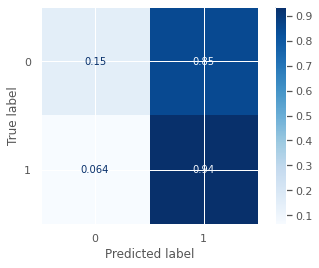

In [128]:
print("######### Portuguese dataset #########")
clf_p = RandomForestClassifier(max_features='sqrt', random_state=0)
clf_p = GridSearchCV(clf_p, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_p.fit(X_train_p_reduced, y_train_p).score(X_test_p_reduced, y_test_p)

RF_acc[0,2] = acc
print(clf_p.best_params_)
print(acc)
print_classification_report(X_train_p_reduced, y_train_p, X_test_p_reduced, y_test_p, clf_p)

##### PCA-reduced dataset and oversampled train set

######### Math dataset smote #########
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   32.6s finished


{'criterion': 'gini', 'n_estimators': 901}
0.810126582278481
              precision    recall  f1-score   support

           0       0.72      0.69      0.71        26
           1       0.85      0.87      0.86        53

    accuracy                           0.81        79
   macro avg       0.79      0.78      0.78        79
weighted avg       0.81      0.81      0.81        79



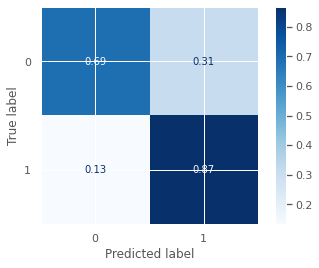

In [129]:
# Parameters Tuning
params_grid = {'n_estimators': np.arange(1,1001,300).tolist(), 'criterion': ['gini','entropy']}

print("######### Math dataset smote #########")
clf_m = RandomForestClassifier(max_features='sqrt', random_state=0)
clf_m = GridSearchCV(clf_m, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_m.fit(X_smote_m, y_smote_m).score(X_test_m_reduced, y_test_m)

RF_acc[0,1] = acc
print(clf_m.best_params_)
print(acc)
print_classification_report(X_smote_m, y_smote_m, X_test_m_reduced, y_test_m, clf_m)

######### Portuguese dataset smote #########
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   54.8s finished


{'criterion': 'gini', 'n_estimators': 901}
0.8384615384615385
              precision    recall  f1-score   support

           0       0.47      0.40      0.43        20
           1       0.89      0.92      0.91       110

    accuracy                           0.84       130
   macro avg       0.68      0.66      0.67       130
weighted avg       0.83      0.84      0.83       130



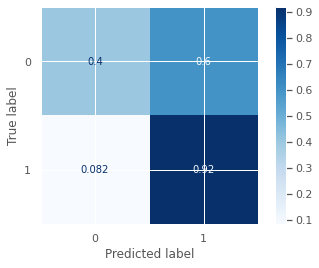

In [130]:
print("######### Portuguese dataset smote #########")
clf_p = RandomForestClassifier(max_features='sqrt', random_state=0)
clf_p = GridSearchCV(clf_p, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_p.fit(X_smote_p, y_smote_p).score(X_test_p_reduced, y_test_p)

RF_acc[0,3] = acc
print(clf_p.best_params_)
print(acc)
print_classification_report(X_smote_p, y_smote_p, X_test_p_reduced, y_test_p, clf_p)

In [131]:
RF_scores = pd.DataFrame(np.round(RF_acc, 2), columns=['Math','Math_smote', 'Portoguese','Portoguese_smote'], index=['Random Forest'])
RF_scores

,Math,Math_smote,Portoguese,Portoguese_smote
Random Forest,0.8,0.81,0.82,0.84


### Conclusions

In [132]:
classification_results = LR_scores.append(KNN_scores).append(SVM_scores_linear).append(SVM_scores_rbf).append(DT_scores).append(RF_scores)
classification_results

,Math,Math_smote,Portoguese,Portoguese_smote
Logistic Regression,0.85,0.86,0.92,0.88
KNN,0.77,0.73,0.86,0.78
SVM linear,0.85,0.85,0.89,0.88
SVM rbf,0.82,0.85,0.91,0.84
Decision Tree,0.76,0.72,0.78,0.78
Random Forest,0.80,0.81,0.82,0.84
